#  <center> Data Science 100 Group Project <center>
## <center> Predicting Age from Systolic Blood Pressure and Cholesterol <center>

## Introduction

In this analysis we use the variables age and systolic blood pressure to predict age using the [Heart Disease Dataset](https://www.kaggle.com/datasets/mirzahasnine/heart-disease-dataset) (by Mirza Hasine, downloaded from kaggle). We took two regression approaches, k-nearest neighbours and linear regression, to explore the results and which engine of regression works best for this dataset.

## Data Analysis

In [1]:
## load packages
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
## read data and mutate response variable to be a factor
url <- "https://raw.githubusercontent.com/Kyleetd/DSCI100-Course-Project-2023/main/heart_disease.csv"

heart_disease_data <- read_csv(url)

head(heart_disease_data)

Rows: 4238 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Gender, education, prevalentStroke, Heart_ stroke
dbl (12): age, currentSmoker, cigsPerDay, BPMeds, prevalentHyp, diabetes, to...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_ stroke
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Male,39,postgraduate,0,0,0,no,0,0,195,106.0,70,26.97,80,77,No
Female,46,primaryschool,0,0,0,no,0,0,250,121.0,81,28.73,95,76,No
Male,48,uneducated,1,20,0,no,0,0,245,127.5,80,25.34,75,70,No
Female,61,graduate,1,30,0,no,1,0,225,150.0,95,28.58,65,103,yes
Female,46,graduate,1,23,0,no,0,0,285,130.0,84,23.10,85,85,No
Female,43,primaryschool,0,0,0,no,1,0,228,180.0,110,30.30,77,99,No


In [1]:
## Filter data and select data so there's no N/A observations in the predictor variables
## Filter data so there's no N/A observations in the predictor variables
heart_disease_filtered <- filter(heart_disease_data, age != "NA", totChol != "NA", sysBP != "NA") 

options(repr.plot.width=12, repr.plot.height=10)
plot <- ggplot(heart_disease_filtered, aes(x = totChol, y = sysBP, color = age)) +
  geom_point() +
  labs(x = "Total Cholesterol (mg/dL)", 
       y = "Systolic Blood Pressure", 
       title = "Total Cholesterol vs Systolic Blood Pressure", 
       caption = "Plot 1") +
  theme_dark() +
  theme(text = element_text(size = 20), plot.title = element_text(face = "bold", hjust = 0.5), plot.caption = element_text(hjust = 0.5))

plot

ERROR: Error in match.arg(method): object 'totChol' not found


Plot 1 shows a weak and spread positive trend in the predictor variables and the response variable. As cholestoral and systolic blood pressure rise in tandem, these data points tend to be associated with higher ages. This leads supports our hypothesis that 

In [4]:
## Establish training and testing data sets
set.seed(5)
heart_disease_split <- initial_split(heart_disease_filtered, prop = 0.75, strata = age)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

### KNN Regression

In [5]:
## Calibrating Parameter K

## Create model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("regression")

## Create recipe, scale and center data
heart_recipe <- recipe(age ~ totChol + sysBP, data = heart_disease_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

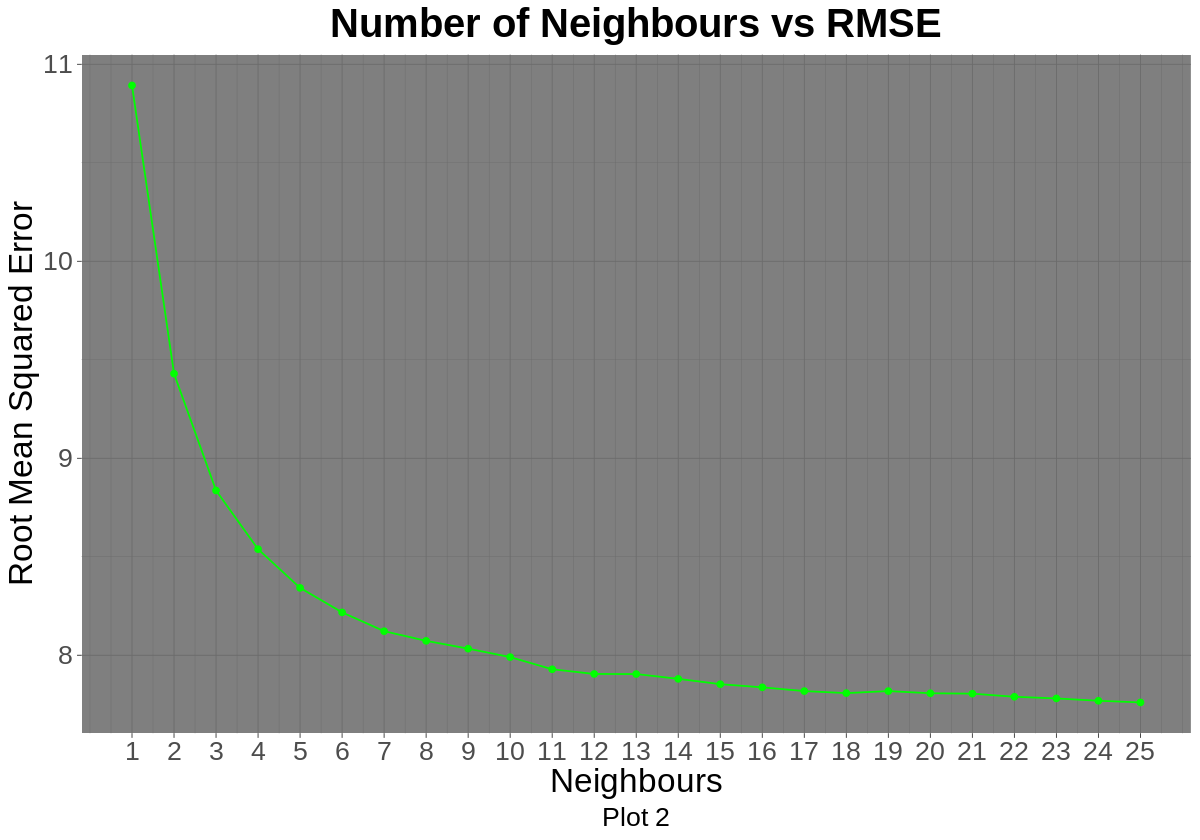

In [6]:
set.seed(5)

# Cross validation
heart_vfold <- vfold_cv(heart_disease_train, v = 10, strata = age) ## use 10

## k values to try
k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

## Create a workflow & get accuracy metrics
heart_accuracies <- workflow() |>
      add_recipe(heart_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = heart_vfold, grid = k_vals) |>
      collect_metrics() |>
      filter(.metric == "rmse")

## Plot the 𝑘 vs the accuracy
options(repr.plot.width=10, repr.plot.height=7)

cross_val_plot <- ggplot(heart_accuracies, aes(x = neighbors, y = mean))+
  geom_point(color = "green") +
  geom_line(color = "green") +
  labs(x = "Neighbours", 
       y = "Root Mean Squared Error", 
       title = "Number of Neighbours vs RMSE", 
       caption = "Plot 2") +
  scale_x_continuous(breaks = round(seq(min(heart_accuracies$neighbors), max(heart_accuracies$neighbors), by = 1),1)) +
  theme_dark() +
  theme(text = element_text(size = 20), plot.title = element_text(face = "bold", hjust = 0.5), plot.caption = element_text(hjust = 0.5))

cross_val_plot

In [7]:
## Select highest accuracy k
k <- heart_accuracies |>
    arrange(mean) |>
    slice(1) |>
    pull(neighbors)
print(sprintf("K: %s", k))

## Get RSME
rsme_knn <- heart_accuracies |>
    arrange(mean) |>
    slice(1) |>
    pull(mean)
print(sprintf("RSME: %s", rsme_knn))

[1] "K: 25"
[1] "RSME: 7.7605914166747"


#### Conducting Classification with Highest Accuracy K

In [8]:
## New model specification
knn_refined_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k) |>
      set_engine("kknn") |>
      set_mode("regression")

## New workflow 
heart_fit <- workflow() |>
      add_recipe(heart_recipe) |>
      add_model(knn_spec) |>
      fit(data = heart_disease_train)

Warning message:
“tune samples were requested but there were 3139 rows in the data. 3134 will be used.”


#### Predict 

In [9]:
set.seed(5) 

## predict on the test dataset using refined model
predictions <- predict(heart_fit, heart_disease_test) |>
      bind_cols(heart_disease_test) ## add prediction column to testing_set dataframe 

## accuracy of this prediction (RMSPE)
metrics <- predictions |>
  metrics(truth = age, estimate = .pred)
  
metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.74147994
rsq,standard,0.07905344
mae,standard,7.43734514


#### Plots for KNN Regression Results

In [2]:
options(repr.plot.width=17, repr.plot.height=7)

knn_plot1 <- predictions |>
  ggplot(aes(x = totChol, y = sysBP, color = age)) +
  geom_point() +
  labs(x = "Cholesterol (mg/dL)", 
       y = "Systolic Blood Pressure (mmHg)", 
       title = "Cholestoral vs Blood Pressure (colour is age)", 
       caption = "Plot 3") +
  theme_dark() +
  theme(text = element_text(size = 20), plot.title = element_text(face = "bold", hjust = 0.5), plot.caption = element_text(hjust = 0.5))

knn_plot2 <- predictions |>
  ggplot(aes(x = totChol, y = sysBP, color = .pred)) +
  geom_point() +
  labs(x = "Cholesterol (mg/dL)", 
       y = "Systolic Blood Pressure (mmHg)", 
       title = "Cholesterol vs Blood Pressure (colour is predicted age)", 
       caption = "Plot 4") +
  theme_dark() +
  theme(text = element_text(size = 20), plot.title = element_text(face = "bold", hjust = 0.5), plot.caption = element_text(hjust = 0.5))

knn_plot1 + knn_plot2 +
  plot_layout(ncol = 2)

ERROR: Error in ggplot(predictions, aes(x = totChol, y = sysBP, color = age)): could not find function "ggplot"


The range of the .pred class on Plot 4 differs drastically from the actual range of the age variable. A plausible reason for this discrepancy is that there is no distinct clustering of the data points. While higher age does tend to be associated with higher level of both predictor variables, the data is still very spread. This can cause an averaging effect when the k nearest neighbours are used. The range of pred suggests that the mean value of the k nearest neighbours is contained in the range around 40.5.

### Linear Regression

In [11]:
## do not need to use cross-validation or standardize (center & scale) the data for linear regression
set.seed(5)

lm_spec <- linear_reg() %>%
                set_engine("lm") %>%
                set_mode("regression")

lm_recipe <- recipe(age ~ totChol + sysBP, data = heart_disease_train)

lm_fit <- workflow() %>%
                add_recipe(lm_recipe) %>%
                add_model(lm_spec) %>%
                fit(data = heart_disease_train)

lm_rmse <- lm_fit %>%
                predict(heart_disease_train) %>%
                bind_cols(heart_disease_train) %>%
                metrics(truth = age, estimate = .pred) %>%
                filter(.metric == 'rmse') %>%
                select(.estimate) %>%
                pull()

print(sprintf("RSME: %s", lm_rmse))

lm_rmspe <- lm_fit %>%
                predict(heart_disease_test) %>%
                bind_cols(heart_disease_test) %>%
                metrics(truth = age, estimate = .pred) %>%
                filter(.metric == 'rmse') %>%
                select(.estimate) %>%
                pull()

print(sprintf("RSMPE: %s", lm_rmspe))

[1] "RSME: 7.66854538232256"
[1] "RSMPE: 7.84938559356337"


K-nearest neighbours regression resulted in a RSME of 7.628 and an RMSPE of 8.741. Linear regression resulted in an RSME of 7.669 and a RMSPE of 7.849. This suggests that linear regression did a slightly better job of predicting on the test data. However, both modes of regression analysis resulted in low error values meaning that the cumulative sum of deviances between the predicted values and the true values was small.

#### Plots for Linear Regression Results

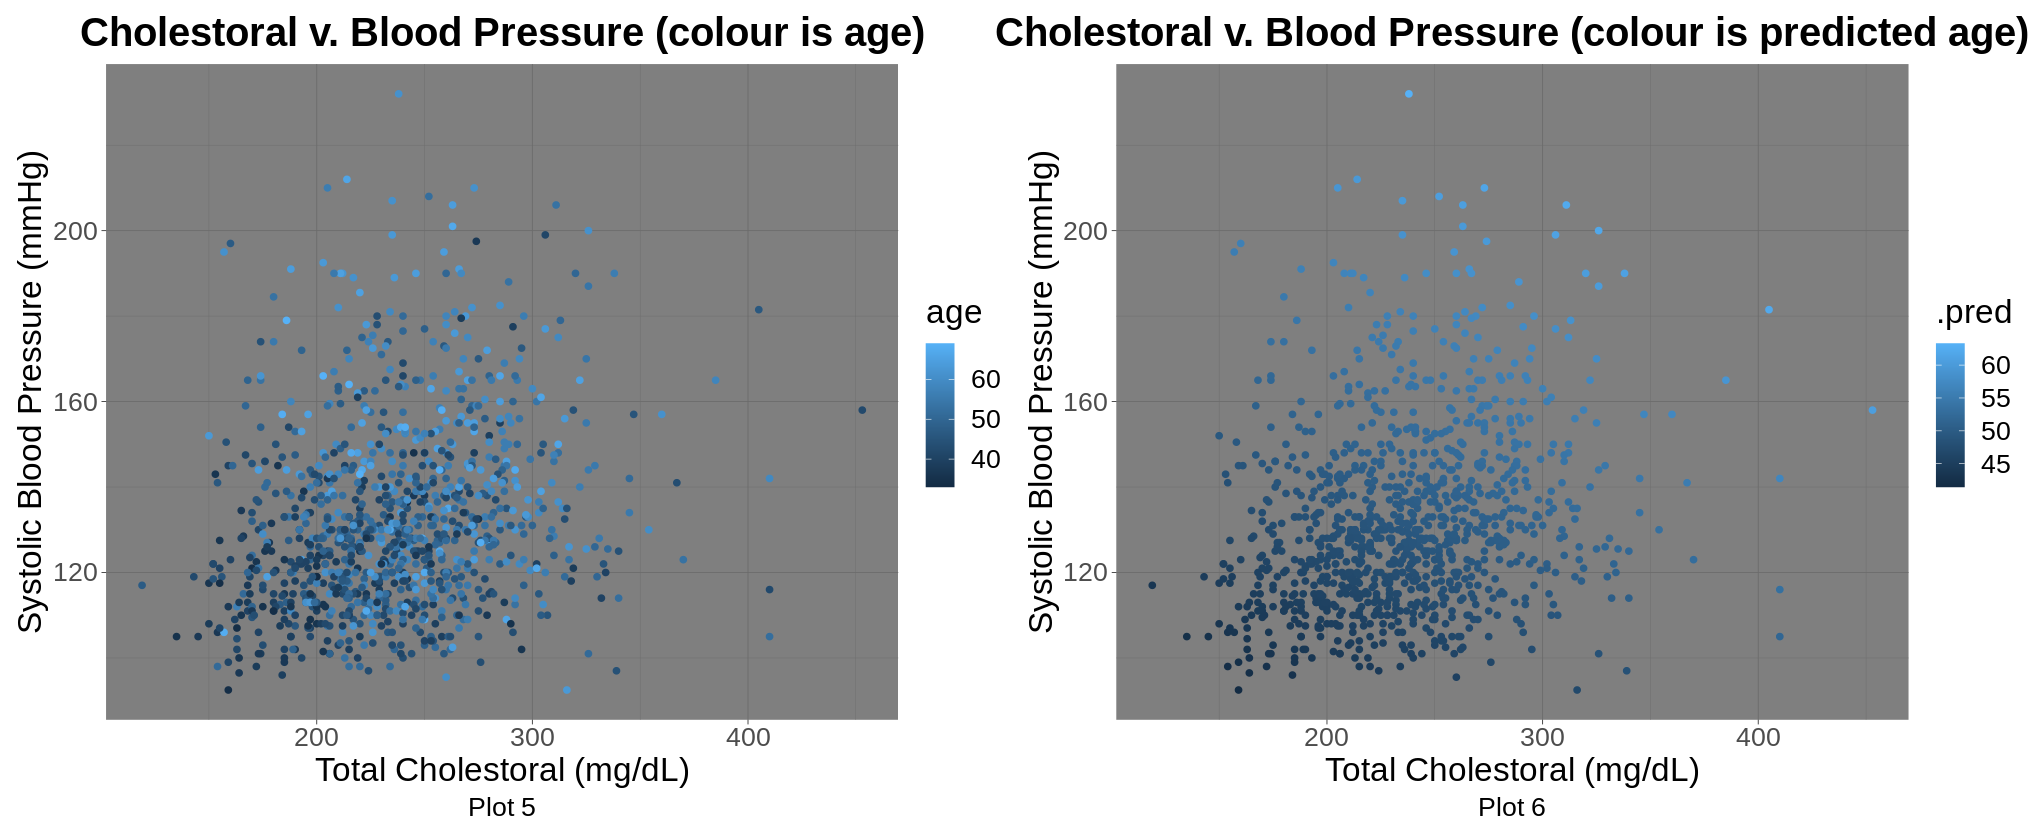

In [12]:
## Predict on testing data and plot 
set.seed(5) 

lm_preds <- predict(lm_fit, heart_disease_test) |>
      bind_cols(heart_disease_test)

options(repr.plot.width=17, repr.plot.height=7)

lm_plot1 <- lm_preds |>
  ggplot(aes(x = totChol, y = sysBP, color = age)) +
  geom_point() +
  labs(x = "Total Cholesterol (mg/dL)", 
       y = "Systolic Blood Pressure (mmHg)", 
       title = "Cholesterol v. Blood Pressure (colour is age)", 
       caption = "Plot 5") +
  theme_dark() +
  theme(text = element_text(size = 20), plot.title = element_text(face = "bold", hjust = 0.5), plot.caption = element_text(hjust = 0.5))

lm_plot2 <- lm_preds |>
  ggplot(aes(x = totChol, y = sysBP, color = .pred)) +
  geom_point() +
  labs(x = "Total Cholesterol (mg/dL)", 
       y = "Systolic Blood Pressure (mmHg)", 
       title = "Cholesterol v. Blood Pressure (colour is predicted age)", 
       caption = "Plot 6") +
  theme_dark() +
  theme(text = element_text(size = 20), plot.title = element_text(face = "bold", hjust = 0.5), plot.caption = element_text(hjust = 0.5))

lm_plot1 + lm_plot2 +
  plot_layout(ncol = 2)